In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter
import math
%matplotlib inline

In [16]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
def denormalize(tensor):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.255]
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor
    
transform = transforms.Compose([
                transforms.RandomResizedCrop(224), 
                transforms.ToTensor(),
                normalize,
                ])

dataset = torchvision.datasets.ImageFolder("data/processed", 
                                           transform=transform)
train_fraction = 0.7
n_train = math.ceil(train_fraction*len(dataset))
n_val = len(dataset) - n_train
dataset_train, dataset_val = torch.utils.data.random_split(dataset, 
                                                           (n_train, n_val))
print(dataset_train)
print(dataset)
classes = dataset.classes
train = torch.utils.data.DataLoader(dataset_train, batch_size=64, shuffle=True)
val = torch.utils.data.DataLoader(dataset_val, batch_size=64, shuffle=True)


Dataset ImageFolder
    Number of datapoints: 6573
    Root Location: data/processed
    Transforms (if any): Compose(
                             RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if any): None


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


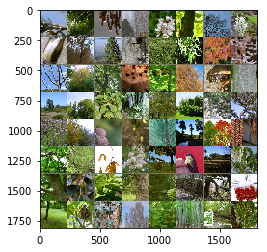

['Sorbus aucuparia', 'Aesculus hippocastanum', 'Alnus glutinosa', 'Pinus sylvestris', 'Robinia pseudoacacia', 'Juglans nigra', 'Acer pseudoplatanus', 'Robinia pseudoacacia', 'Juglans nigra', 'Quercus robur', 'Pinus sylvestris', 'Carpinus betulus', 'Fagus sylvatica', 'Betula pendula', 'Liquidambar styraciflua', 'Fagus sylvatica', 'Ailanthus altissima', 'Acer campestre', 'Acer platanoides', 'Sorbus aucuparia', 'Juglans nigra', 'Betula pendula', 'Quercus robur', 'Ailanthus altissima', 'Pinus sylvestris', 'Acer platanoides', 'Acer negundo', 'Fagus sylvatica', 'Sorbus aucuparia', 'Fagus sylvatica', 'Juglans nigra', 'Pinus nigra', 'Juglans nigra', 'Morus nigra', 'Aesculus hippocastanum', 'Ulmus pumila', 'Pinus nigra', 'Pinus sylvestris', 'Acer platanoides', 'Alnus glutinosa', 'Aesculus hippocastanum', 'Aesculus hippocastanum', 'Acer pseudoplatanus', 'Aesculus hippocastanum', 'Aesculus hippocastanum', 'Juglans nigra', 'Pinus sylvestris', 'Robinia pseudoacacia', 'Acer platanoides', 'Fagus sylv

In [18]:
iterator = iter(train)
batch, labels = iterator.next()
def plot_batch(batch):
    grid = torchvision.utils.make_grid(batch, nrow=8)
    images = denormalize(grid).numpy()
    plt.imshow(np.transpose(images, (1, 2, 0)))
    plt.show()
    print([classes[x] for x in labels])
plot_batch(batch)

In [13]:
from torchvision import models
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, len(classes))

In [14]:
output = model(batch)
_, predictions = torch.max(output, 1)

In [15]:
print(predictions)

tensor([23, 19, 12, 11, 19, 19, 29, 11, 12, 17, 11,  4, 11, 11, 12, 11])


In [19]:
model.train()
optimiser = torch.optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()

writer = SummaryWriter('boardlog/three')

for iteration, (batch, labels) in enumerate(train):
    optimiser.zero_grad()
    outputs = model(batch)
    _, predictions = torch.max(outputs, 1)
    loss = criterion(outputs, labels)
    loss.backward()
    optimiser.step()
    corrects = torch.sum(predictions == labels)
    print(f"loss={loss.item()}, num correct={corrects.item()}")
    writer.add_scalar('loss', loss, iteration)
    writer.add_scalar('acc', corrects, iteration)

loss=3.647019147872925, num correct=3


/home/justin/code/CHH-Trees/venv/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/justin/code/CHH-Trees/venv/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2284257280 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/justin/code/CHH-Trees/venv/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 19599982592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/justin/code/CHH-Trees/venv/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684485632 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


loss=3.806947946548462, num correct=1
loss=3.7021079063415527, num correct=0
loss=3.5831491947174072, num correct=2
loss=3.491103410720825, num correct=4
loss=3.488053560256958, num correct=4
loss=3.4965407848358154, num correct=3
loss=3.337266683578491, num correct=4
loss=3.2623770236968994, num correct=4
loss=3.332052230834961, num correct=5
loss=3.2136988639831543, num correct=8
loss=3.3414645195007324, num correct=6
loss=3.152777910232544, num correct=7
loss=3.203537940979004, num correct=8
loss=3.2538156509399414, num correct=6
loss=3.072782039642334, num correct=8
loss=3.080085277557373, num correct=10
loss=3.041077136993408, num correct=13
loss=3.1007916927337646, num correct=10
loss=3.0961644649505615, num correct=10
loss=3.1741247177124023, num correct=10


/home/justin/code/CHH-Trees/venv/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1024000000 bytes but only got 0. Skipping tag 57856
  " Skipping tag %s" % (size, len(data), tag))


loss=3.003810405731201, num correct=15
loss=3.0276317596435547, num correct=9
loss=2.9290409088134766, num correct=17
loss=2.859218120574951, num correct=19
loss=2.9257662296295166, num correct=12
loss=2.8441176414489746, num correct=16
loss=3.040153980255127, num correct=11
loss=3.1095006465911865, num correct=11
loss=3.0686111450195312, num correct=7
loss=2.9050638675689697, num correct=12
loss=3.1483261585235596, num correct=6
loss=3.037134885787964, num correct=12
loss=3.0415422916412354, num correct=9
loss=3.1786413192749023, num correct=7
loss=3.0678865909576416, num correct=9
loss=2.955244302749634, num correct=12
loss=2.742434501647949, num correct=20
loss=3.117624521255493, num correct=13
loss=3.323678493499756, num correct=3
loss=3.0226337909698486, num correct=15
loss=2.8790900707244873, num correct=15
loss=3.036616802215576, num correct=12
loss=3.0068352222442627, num correct=13
loss=2.8296096324920654, num correct=21
loss=3.275648832321167, num correct=7
loss=2.86215639114

/home/justin/code/CHH-Trees/venv/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 37093376 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/justin/code/CHH-Trees/venv/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20054016 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/justin/code/CHH-Trees/venv/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:771: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 10. 
  warnings.warn(str(msg))


loss=2.7357161045074463, num correct=19
loss=2.9956252574920654, num correct=12
loss=2.911983013153076, num correct=7
loss=2.801090717315674, num correct=17
loss=2.7910408973693848, num correct=13
loss=2.6917881965637207, num correct=17
loss=2.868107795715332, num correct=11
loss=2.822035789489746, num correct=15
loss=3.0996878147125244, num correct=7
loss=3.087137460708618, num correct=7
loss=2.9243133068084717, num correct=12
loss=2.8579068183898926, num correct=14
loss=3.3824074268341064, num correct=5
loss=2.7687253952026367, num correct=15
loss=2.74698805809021, num correct=14
loss=2.725895404815674, num correct=20
loss=2.616910219192505, num correct=15
loss=2.883331060409546, num correct=12
loss=2.641857147216797, num correct=18
loss=2.872089147567749, num correct=15
loss=2.898050546646118, num correct=11
loss=2.8796234130859375, num correct=13
loss=2.7494232654571533, num correct=11
loss=2.9197702407836914, num correct=9
